<a href="https://colab.research.google.com/github/macsakini/Financial-Modelling/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -U tensorflow-addons

     |████████████████████████████████| 1.1 MB 7.9 MB/s 


In [3]:
#import de[endancies]
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

In [17]:
num_classes = 100
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


In [6]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [15]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


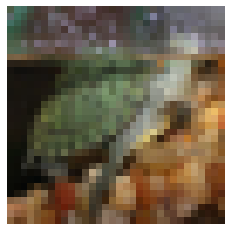

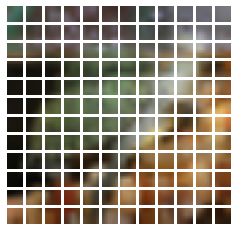

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [55]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import PCA

In [89]:
x_flat = np.array(x_train[0]).reshape((3072))
print(x_flat.shape)

(3072,)


(32, 32, 3)

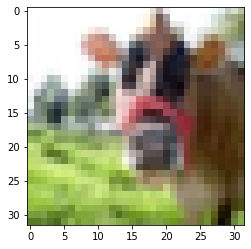

In [65]:
plt.imshow(x_train[0])
x_train[0].shape

In [77]:
pca_dims = PCA()
pca_dims.fit(x_flat)
cumsum = np.cumsum(pca_dims.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [72]:
d

1

In [80]:
pca = PCA(n_components=d)
x_reduced = pca.fit_transform(x_flat)
X_recovered = pca.inverse_transform(x_reduced)
print("reduced shape: " + str(X_reduced.shape))
print("recovered shape: " + str(X_recovered.shape))

reduced shape: (3072, 1)
recovered shape: (3072, 1)


ValueError: ignored

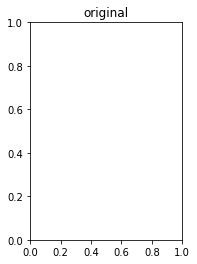

In [83]:
f = plt.figure()
f.add_subplot(1,2, 1)
plt.title("original")
plt.imshow(x_flat.reshape((32,32)))
f.add_subplot(1,2, 2)

plt.title("PCA compressed")
plt.imshow(X_recovered[0].reshape((64,64)))
plt.show(block=True)

In [43]:
import tensorflow_hub as hub
import pandas as pd

# Loading model directly from TensorFlow Hub
detector = hub.load("https://tfhub.dev/tensorflow/efficientdet/lite2/detection/1")

In [46]:
detected = detector(rgb_tensor)
print(detected)

(<tf.Tensor: shape=(1, 100, 4), dtype=float32, numpy=
array([[[4.58283567e+00, 1.41907287e+00, 3.19790230e+01, 3.19275360e+01],
        [1.29255915e+01, 1.40594425e+01, 3.18646431e+01, 3.18621082e+01],
        [7.21502066e+00, 0.00000000e+00, 3.10773525e+01, 8.32457352e+00],
        [8.91738129e+00, 7.70593166e+00, 3.18075886e+01, 3.14441929e+01],
        [1.34376268e+01, 1.64140415e+01, 2.38580551e+01, 2.76790695e+01],
        [2.57598839e+01, 7.69255534e-02, 3.17262726e+01, 6.95225620e+00],
        [1.83139038e+01, 3.49643171e-01, 3.18104038e+01, 1.43690186e+01],
        [8.85235965e-02, 1.61994858e+01, 7.04362965e+00, 3.16919098e+01],
        [7.87499905e+00, 2.61002274e+01, 2.68342476e+01, 3.19236660e+01],
        [1.92322597e-01, 3.47244215e+00, 6.58610249e+00, 1.27809343e+01],
        [1.39273863e+01, 2.20517502e+01, 1.90695133e+01, 2.73556538e+01],
        [2.39192028e+01, 1.83397884e+01, 3.17833443e+01, 2.38192024e+01],
        [2.45508614e+01, 1.39022274e+01, 3.17634335e+01, 1

In [51]:
# Augment data.
augmented = data_augmentation(num_detections)
    # Create patches.
patches = Patches(patch_size)(augmented)
    # Encode patches.
encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)


In [54]:
# Creating prediction
boxes, scores, classes, num_detections = detector(rgb_tensor)
print(scores)

tf.Tensor(
[[0.3823064  0.22214381 0.11479084 0.06950238 0.05858053 0.05751989
  0.04902959 0.04683714 0.0454725  0.04171178 0.04045891 0.03972973
  0.03665283 0.03653493 0.03582112 0.0316889  0.03079224 0.02851656
  0.02827696 0.02757451 0.02647692 0.02575319 0.02563557 0.02137173
  0.02033445 0.02012597 0.02008221 0.02004574 0.0178508  0.01723971
  0.01717679 0.01674753 0.01628686 0.01560945 0.0149337  0.01474387
  0.01438713 0.01387179 0.01350875 0.01347315 0.01323273 0.01278175
  0.01256917 0.01181446 0.01178057 0.01108327 0.01097485 0.01091113
  0.01077004 0.01061583 0.01044979 0.01034879 0.01028836 0.01024963
  0.01015257 0.00961524 0.00945299 0.00937186 0.00913937 0.00875043
  0.00870344 0.00865131 0.00841532 0.00837756 0.00837226 0.00825275
  0.00807078 0.00795358 0.00772262 0.00766506 0.00764312 0.00761151
  0.00754652 0.00750204 0.0073301  0.00721186 0.00715069 0.00712463
  0.00708875 0.00684811 0.00679265 0.00675827 0.00675721 0.00658025
  0.00648875 0.00642053 0.00631899 0.

In [19]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [24]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [20]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [21]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [ ]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/100
 18/176 [==>...........................] - ETA: 36:36 - loss: 5.5061 - accuracy: 0.0178 - top-5-accuracy: 0.0705